# Model Inspection

In this notebook tutorial, we will look atinspection before and during the simulation. In Causal, the simulation consists of multiple stages. The first stage is the inspection stage. In this stage, the model is inspected to see whether the model has any inconsistencies, such as the existance of unterminated ports or algebraic loops etc., the simulation is terminated. In case the inconsistency is removed from the model(eg. breking of algebric loops), the simulation continues. Otherwise, the simulation is halted by reporting the inconsistency. Even if the model is inspected and nothing wrong is detected, it is still possible that errors may be thrown during the run stage of the simulation. In the run, this possibility is checked and if an error occurs the simulation is terminated. 

### Unterminated Ports

In Causal, data flows through the connections of the model. The connnections are actulaly a bunch of links that are built upon Julia unbufferred channels. In order data to flow through these channels, tasks that reads/writes to these channels are launched.

Ports are the gates of the components in Causal. Each component in reads data from its input port, and writes data to its output port. The flow through the ports are carried out through the connections that connects the ports. The ports of the components are bound to connections. So, all the ports of the model must be connected to other ports. Otherwise, if a port in not connected to other ports, then the simulation is got stuck while trying to read/write data to that unterminated ports. 

Before the simulation these unterminated ports are inspected. In case an unterminated porti detected, the simulaiton is directly terminated here. 

In [2]:
using Causal 

# Describe model 
@defmodel model begin 
    @nodes begin 
        gen = SinewaveGenerator() 
        gain = Gain() 
        writer = Writer() 
    end
    @branches begin 
        gain => writer # Note that the output of `gen` is not connected. 
    end 
end

# Simulate the model 
sim = simulate!(model)

[ Info: 2020-08-18T13:55:26.172 Started simulation...
[ Info: 2020-08-18T13:55:26.51 Inspecting model...


ErrorException: Output port of SinewaveGenerator(amp:1.0, freq:1.0, phase:0.0, offset:0.0, delay:0.0) has unbound pins at index [1]

Not that the simulation was not run. Since the output of `gen` is not connected to any other port. This was reported in detail in the error message thrown. 

Now, let us fix the error. 

In [3]:
# Describe model 
@defmodel model begin 
    @nodes begin 
        gen = SinewaveGenerator() 
        gain = Gain() 
        writer = Writer() 
    end
    @branches begin 
        gen => gain 
        gain => writer 
    end 
end

# Simulate the model 
sim = simulate!(model)

[ Info: 2020-08-18T13:55:58.027 Started simulation...
[ Info: 2020-08-18T13:55:58.028 Inspecting model...
[ Info: 2020-08-18T13:55:58.204 Done.
[ Info: 2020-08-18T13:55:58.205 Initializing the model...
[ Info: 2020-08-18T13:55:58.658 Done...
[ Info: 2020-08-18T13:55:58.659 Running the simulation...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
[ Info: 2020-08-18T13:55:59.554 Done...
[ Info: 2020-08-18T13:55:59.554 Terminating the simulation...
[ Info: 2020-08-18T13:55:59.704 Done.


Simulation(state:done, retcode:success, path:/tmp/Simulation-d94518ce-d410-49ca-b614-41465c6ecf94)

Now the simulation is started an run with success. 

### Breaking Algebraic Loops

During the model inspection, the detection and breaking of algebraic loops is carried out automatically. An algebraic loop is a closed-loop consisting of one or more components whose outputs are directly dependent on their inputs. If algebraic loops exist in a model, the simulation gets stuck because none of the components in the loop can generate output to break the loop. Such a problem can be broken by rearranging the model without algebraic loops, solving the feed-forward algebraic equation of the loop, or inserting a memory component with a certain initial condition anywhere in the loop. Causal provides all these loop-breaking solutions. During the inspection stage, in case they are detected, all the loops are broken. Otherwise, a report is printed to notify the user to insert memory components to break the loops.

See the following example.

In [4]:
# Describe the model
@defmodel model begin
    @nodes begin
        gen = RampGenerator()
        adder = Adder(signs=(+,-))
        gain = Gain()
        writerout = Writer()
        writerin = Writer()
    end
    @branches begin
        gen[1] => adder[1]
        adder[1] => gain[1]
        gain[1] => adder[2]
        gen[1] => writerin[1]
        gain[1] => writerout[1]
    end
end

`model` includes an algebraic loop consisting of the nodes `adder` and `gain`. Each node in the model has an index and the index of `adder` and `gain` is 2 and 3 respectively. This loop is detected and broken automatically in the inspect stage before running the simulation. 

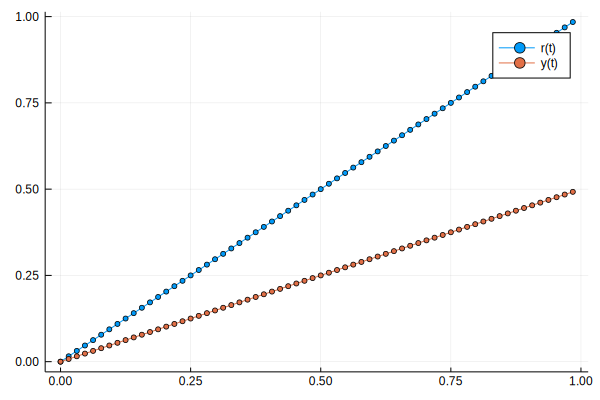

In [8]:
# Simulate the model
ti, dt, tf = 0., 1. / 64., 1.
sim = simulate!(model, ti, dt, tf, withbar=false)

# Read the simulation data and plot
using Plots; theme(:default)
t, y = read(getnode(model, :writerout).component)
t, r = read(getnode(model, :writerin).component)
plot(t, r, label="r(t)", marker=(:circle, 3))
plot!(t, y, label="y(t)", marker=(:circle, 3))

It is also possible to break the algebraci loops with `Memory` components. See, https://zekeriyasari.github.io/Causal.jl/dev/tutorials/algebraic_loops/ for more information.

### Errors Thrown During Run Stage

During the run stage, some kind of errors can be thrown that kills the tasks launched for each component. In case a kind of error is thrown during the run stage of the simulation, those errors are deteced automatically, the simulation is terminated and the error message is reported on console. See the example below.

For example, and `AbstractODESystem` must be mutable type. Assume that one extends the component library by adding a new type that under `AbstractODESystem`.

In [12]:
@def_ode_system struct MySystem{RH, RO, ST, IP, OP} <: AbstractODESystem 
    righthandside::RH = (dx, x, u, t) -> (dx .= -x)
    readout::RO = (x, u, t) -> x 
    state::ST = [1.] 
    input::IP = nothing 
    output::OP = Outport() 
end

Note that `MySystem` is not mutable. But during the simulation, the current time `t` and `state` of `MySystem` are to be updated. While this is tried, an error is thrown complaining about the immutablity of `MySystem`. When this error is thrown, the simulation is haltd directly and the error message is reported. To see this, let us construct a very simple model containing `MySystem` and try to simulate it. 

In [13]:
@defmodel model begin 
    @nodes begin
        ds = MySystem()
        writer = Writer()
    end
    @branches begin
        ds => writer 
    end
end 

simulate!(model, 0, 0.01, 10)


[ Info: 2020-08-18T14:13:24.019 Started simulation...
[ Info: 2020-08-18T14:13:24.019 Inspecting model...
[ Info: 2020-08-18T14:13:24.035 Done.
[ Info: 2020-08-18T14:13:24.035 Initializing the model...
[ Info: 2020-08-18T14:13:24.056 Done...
[ Info: 2020-08-18T14:13:25.636 Running the simulation...
┌ Error: Failed for MySystem{var"#8#17",var"#9#18",Array{Float64,1},Nothing,Outport{Outpin{Float64}},Inpin{Float64},Outpin{Bool},Nothing,Base.UUID,Tuple{},NamedTuple{(),Tuple{}},Tuple{},NamedTuple{(),Tuple{}},OrdinaryDiffEq.Tsit5,OrdinaryDiffEq.ODEIntegrator{OrdinaryDiffEq.Tsit5,true,Array{Float64,1},Nothing,Float64,Nothing,Float64,Float64,Float64,Array{Array{Float64,1},1},DiffEqBase.ODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,1},1},1},DiffEqBase.ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Nothing,DiffEqBase.ODEFunction{true,var"#8#17",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,

TaskFailedException: TaskFailedException:
setfield! immutable struct of type MySystem cannot be changed
Stacktrace:
 [1] setproperty! at ./Base.jl:34 [inlined]
 [2] evolve! at /home/sari/.julia/dev/Causal/src/components/componentsbase/takestep.jl:98 [inlined]
 [3] forwardstep at /home/sari/.julia/dev/Causal/src/components/componentsbase/takestep.jl:131 [inlined]
 [4] takestep! at /home/sari/.julia/dev/Causal/src/components/componentsbase/takestep.jl:121 [inlined]
 [5] macro expansion at /home/sari/.julia/dev/Causal/src/components/componentsbase/takestep.jl:162 [inlined]
 [6] (::Causal.var"#55#56"{MySystem{var"#8#17",var"#9#18",Array{Float64,1},Nothing,Outport{Outpin{Float64}},Inpin{Float64},Outpin{Bool},Nothing,Base.UUID,Tuple{},NamedTuple{(),Tuple{}},Tuple{},NamedTuple{(),Tuple{}},OrdinaryDiffEq.Tsit5,OrdinaryDiffEq.ODEIntegrator{OrdinaryDiffEq.Tsit5,true,Array{Float64,1},Nothing,Float64,Nothing,Float64,Float64,Float64,Array{Array{Float64,1},1},DiffEqBase.ODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,1},1},1},DiffEqBase.ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Nothing,DiffEqBase.ODEFunction{true,var"#8#17",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem},OrdinaryDiffEq.Tsit5,OrdinaryDiffEq.InterpolationData{DiffEqBase.ODEFunction{true,var"#8#17",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Tsit5Cache{Array{Float64,1},Array{Float64,1},Array{Float64,1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}}},DiffEqBase.DEStats},DiffEqBase.ODEFunction{true,var"#8#17",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},OrdinaryDiffEq.Tsit5Cache{Array{Float64,1},Array{Float64,1},Array{Float64,1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}},OrdinaryDiffEq.DEOptions{Float64,Float64,Float64,Float64,typeof(DiffEqBase.ODE_DEFAULT_NORM),typeof(LinearAlgebra.opnorm),DiffEqBase.CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,DataStructures.LessThan},DataStructures.BinaryHeap{Float64,DataStructures.LessThan},Nothing,Nothing,Int64,Array{Float64,1},Array{Float64,1},Array{Float64,1}},Array{Float64,1},Float64,Nothing,OrdinaryDiffEq.DefaultInit}}})() at ./task.jl:358

As expected when the error is thrown the simulation is halted.